In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect, distinct
from flask import Flask, jsonify

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Creating a base with SQLA to generate Python classes from the .sqlite file

# reflect an existing database into a new model
base = automap_base()

#Use the base to reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
pastyear_df = pd.read_sql('SELECT * FROM measurement WHERE date >= (select Date(Max(date),"-1 year") from Measurement)order by date', engine)
pastyear_df.head()

,id,station,date,prcp,tobs
0,2364,USC00519397,2016-08-23,0.00,81.0
1,5091,USC00513117,2016-08-23,0.15,76.0
2,7331,USC00514830,2016-08-23,0.05,80.0
3,8825,USC00517948,2016-08-23,NaN,80.0
4,11851,USC00519523,2016-08-23,0.02,80.0


In [11]:
# Perform a query to retrieve the data and precipitation scores
pastyear_precip = pastyear_df[["date", "prcp"]].set_index('date')

In [12]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
pastyear_precip

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [13]:
# Sort the dataframe by date
pastyear_precip = pastyear_precip.sort_values("date", ascending=False)
pastyear_precip.head()

,prcp
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.50


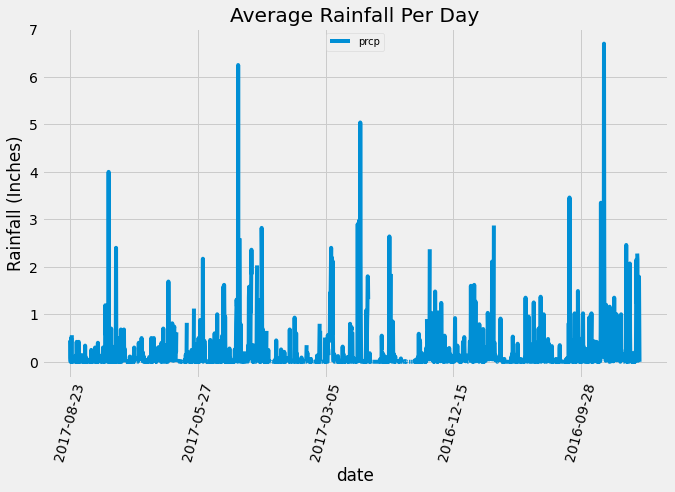

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
pastyear_precip.plot(title="Average Rainfall Per Day", figsize=(10,6))
plt.xticks(rotation=75)
plt.legend(loc='upper center', prop={'size': 10})
plt.ylabel("Rainfall (Inches)")
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
pastyear_precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(station.station))).all()

[(9)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stationcount = [measurement.station, func.count(measurement.date)]
active_stations = session.query(*stationcount).group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_used_station = [measurement.station,func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
station_temp = session.query(*most_used_station).filter(measurement.station == 'USC00519281').\
        group_by(measurement.station)
for station in station_temp:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
qry = [measurement.date, measurement.tobs]
temp_obvs =  pd.read_sql('SELECT tobs FROM measurement WHERE date >= (select Date(Max(date),"-1 year") from Measurement)order by date', engine)
temp_obvs.head()

,tobs
0,81.0
1,76.0
2,80.0
3,80.0
4,80.0


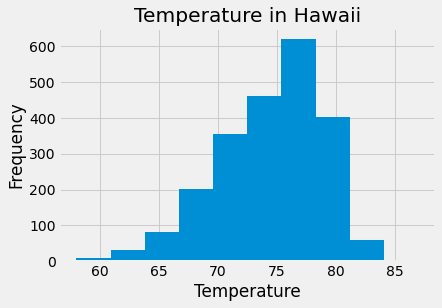

In [20]:
temp_obvs.hist()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature in Hawaii")
plt.show()

# Close Session

In [21]:
# Close Session
session.close()